                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 15 09:39:43 AM: Your problem has 3000 variables, 62 constraints, and 0 parameters.
(CVXPY) Feb 15 09:39:43 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 15 09:39:43 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 15 09:39:43 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 15 09:39:43 AM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Feb 15 09:39:43 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuff

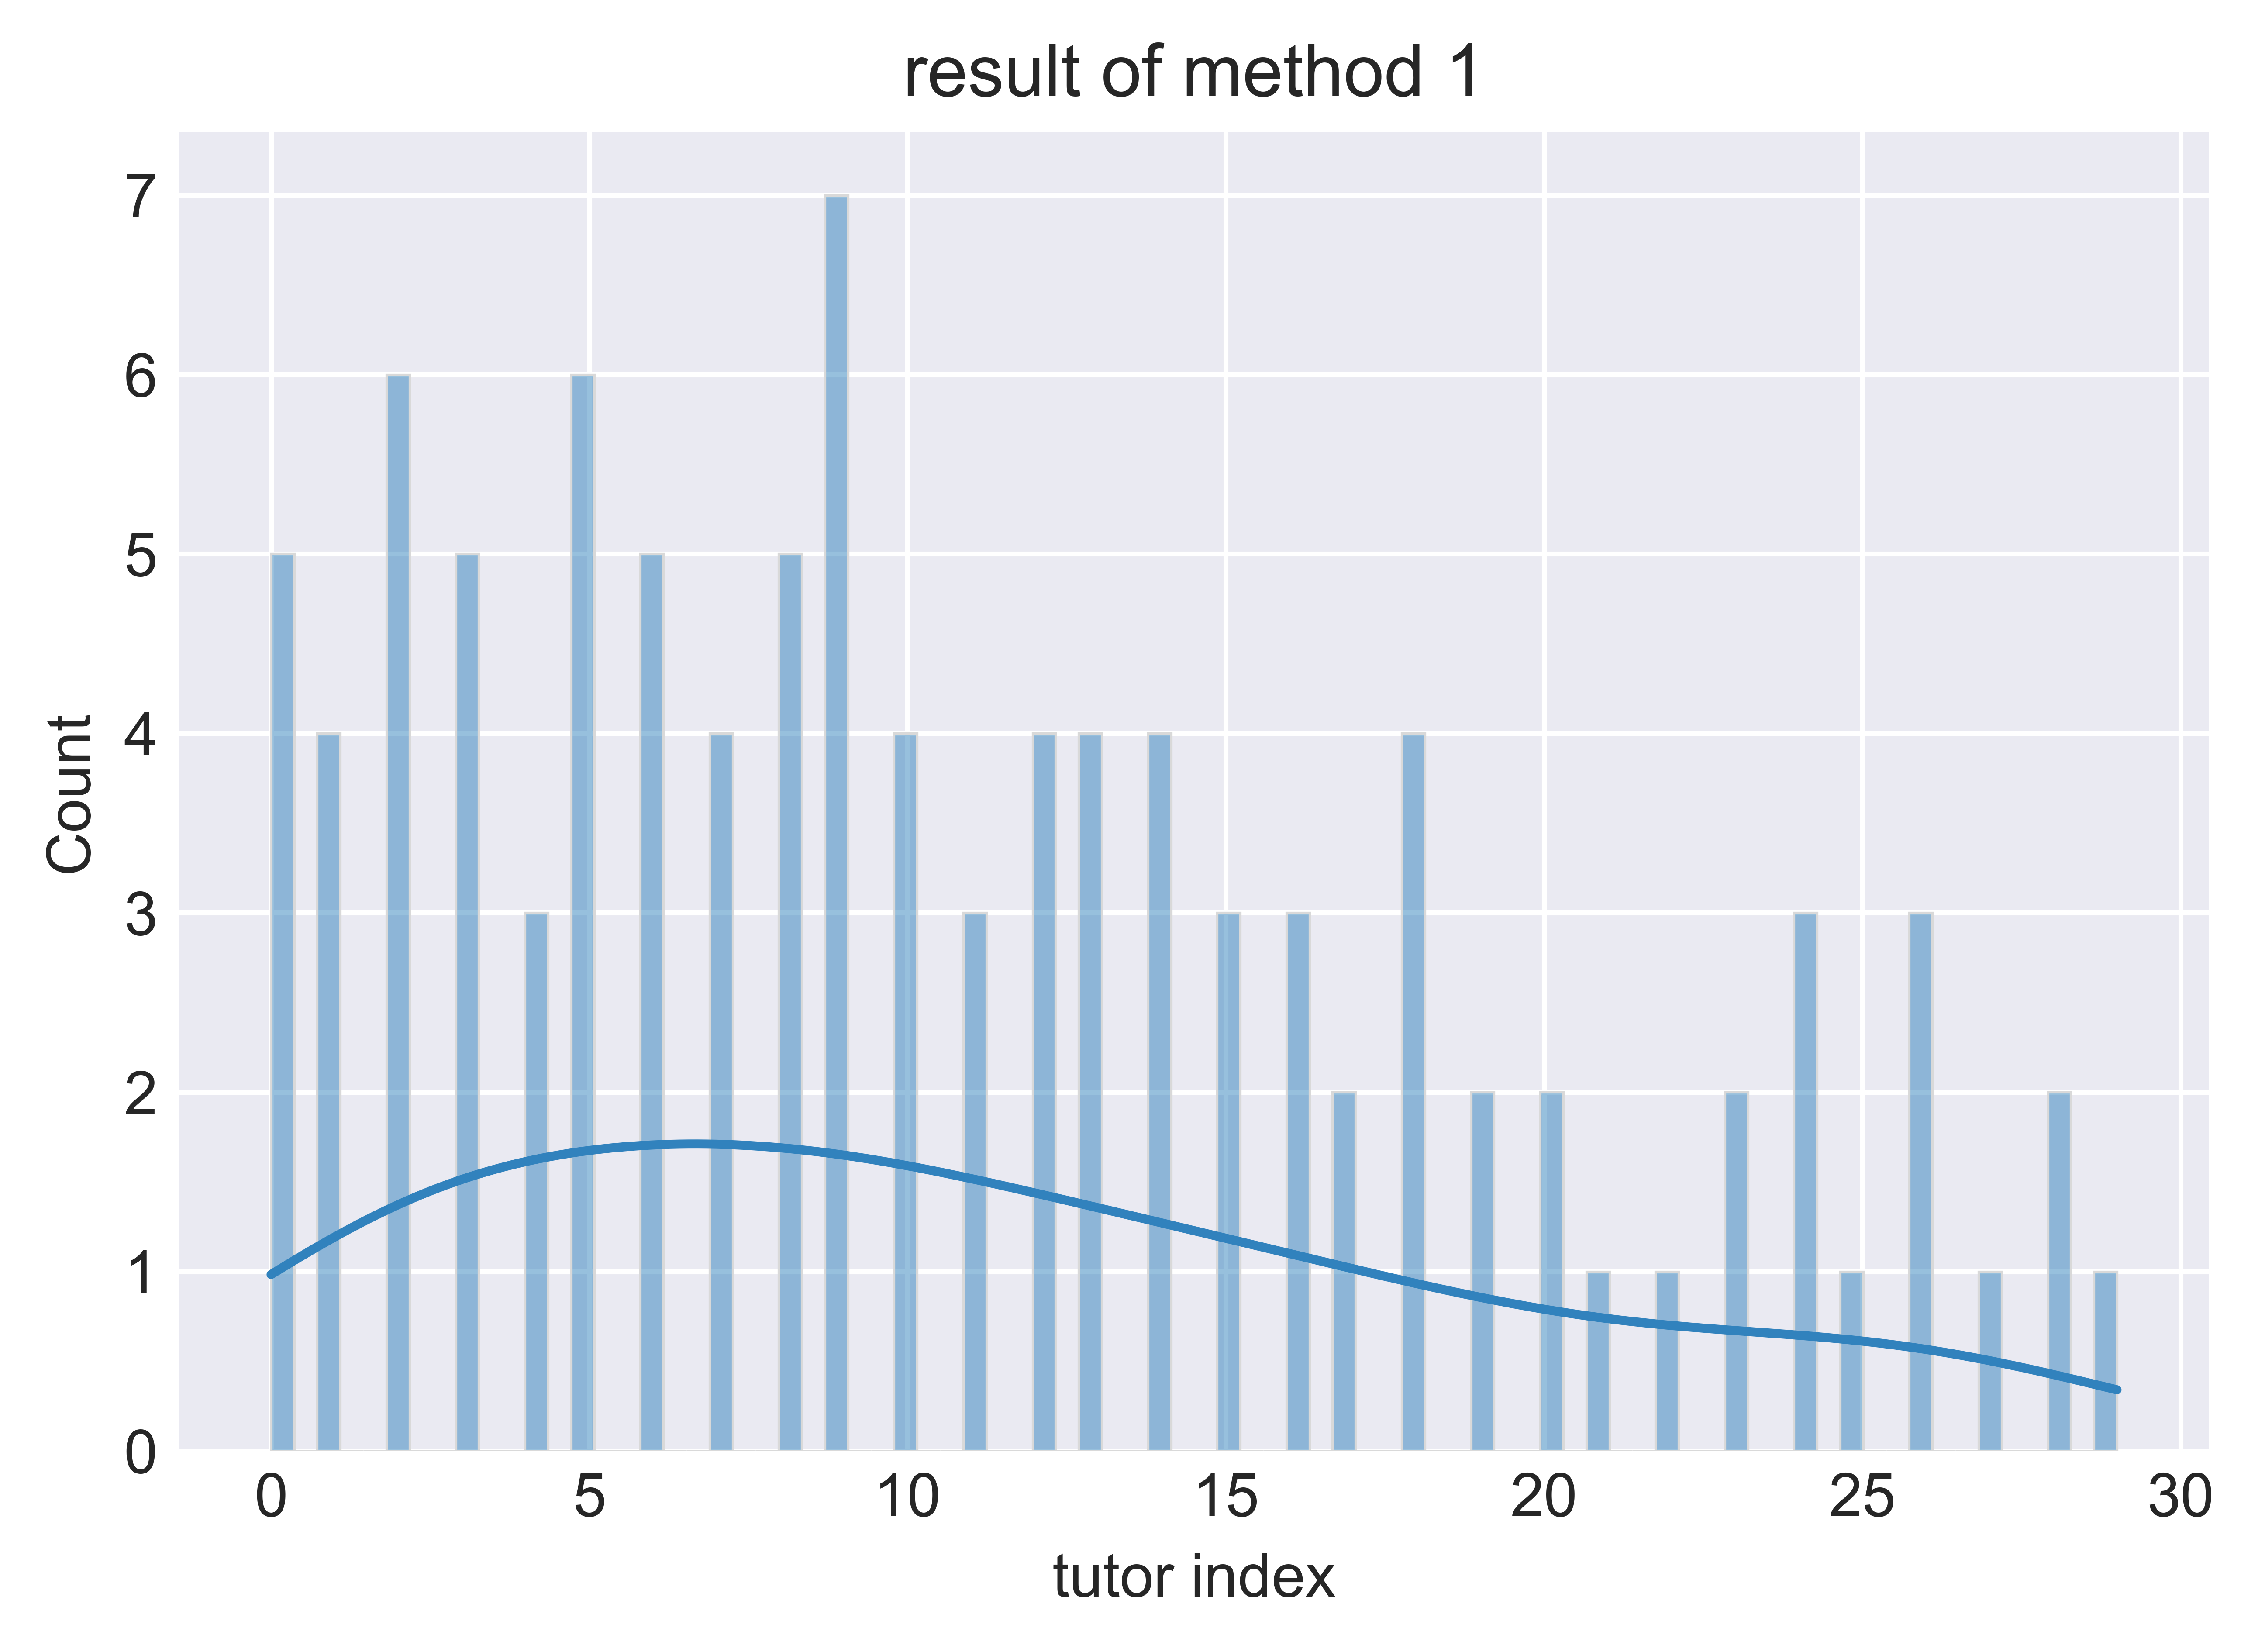

In [4]:
import cvxpy as cp
from mip_cvxpy import PYTHON_MIP

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

student = pd.read_csv("studentdata.csv")
tutorslist = pd.read_csv("tutordata.csv")

#########################################################
# 变量声明
x = cp.Variable(shape=(student.shape[0],tutorslist.shape[0]),boolean=True)

constraints=[]
#########################################################
# 加入约束1
constraints.append(x@np.ones((tutorslist.shape[0],1)) <= np.ones((student.shape[0],1)))
constraints.append(x@np.ones((tutorslist.shape[0],1)) >= np.ones((student.shape[0],1)))
#########################################################
# 加入约束2
for i in range(0,tutorslist.shape[0]):
    constraints.append((np.ones((1,student.shape[0]))@x)[0][i] <= tutorslist["upper"][i])
    constraints.append((np.ones((1,student.shape[0]))@x)[0][i] >= tutorslist["lower"][i])

sum = 0
for  i in range(0,student.shape[0]):
    t = np.zeros((tutorslist.shape[0],1))
    for j in range(1,5):
        t[student.iloc[i,j]] = 1
    for j in range(5,9):
        for k in range(0,tutorslist.shape[0]):
            # categories for a tutor
            if(student.iloc[i,j] in tutorslist.iloc[k,1:5].values.tolist()):
                t[k] = 1
    sum += x[i]@t           


obj = cp.Minimize(-sum)
prob = cp.Problem(obj,constraints=constraints)
prob.solve(solver='GLPK_MI',verbose=True)

print("\nThe optimal value is", prob.value)
print("A solution x is")
output = []
for item in x.value:
    for i in range(0,tutorslist.shape[0]):
        if item[i]==1:
            output.append(i)
print(x.shape)
print(output)

plt.figure(dpi=1000)
plt.style.use('seaborn-darkgrid') #'seaborn-bright'
palette = plt.get_cmap('tab20c')#'Pastel2') # 'Set1' 
figer = sns.histplot(output,kde = True,bins=80,shrink = 1, color = palette.colors[0], edgecolor = palette.colors[-1])#"none")#, element="step")# element = "poly") # cumulative = True
figer.set_title("result of method 1")
figer.set_xlabel("tutor index")
plt.savefig("m1_1.svg",dpi=2000)

In [5]:
top1 = np.zeros((20,6))
# 对于所有学生
for i in range(0,student.shape[0]):
    # 对于它可选的导师
    for j in range(0,tutorslist.shape[0]):
        # 选中某个导师
        if x.value[i][j]==1:
            # 学生的志愿排序
            flag = 0
            for w in range(1,5):
                if student.iloc[i,w] in tutorslist.iloc[j,1:4].values.tolist():
                    top1[student.iloc[i,w]-1][w] +=1
                    flag = 1
                    break
            if flag==0:
                top1[tutorslist.iloc[j,1]][5]+=1
for i in range(0,20):
    top1[i][0] = i+1

In [6]:
top = pd.DataFrame(top1,columns=["index","top1","top2","top3","top4","not in top list"])
top

,index,top1,top2,top3,top4,not in top list
0,1.0,0.0,2.0,2.0,0.0,0.0
1,2.0,2.0,0.0,1.0,3.0,7.0
2,3.0,1.0,1.0,1.0,1.0,6.0
3,4.0,3.0,1.0,0.0,3.0,6.0
4,5.0,0.0,0.0,0.0,1.0,5.0
5,6.0,2.0,3.0,4.0,1.0,1.0
6,7.0,2.0,1.0,0.0,0.0,0.0
7,8.0,0.0,0.0,0.0,0.0,0.0
8,9.0,1.0,1.0,0.0,1.0,1.0
9,10.0,0.0,1.0,0.0,0.0,6.0


<Figure size 6000x4000 with 0 Axes>

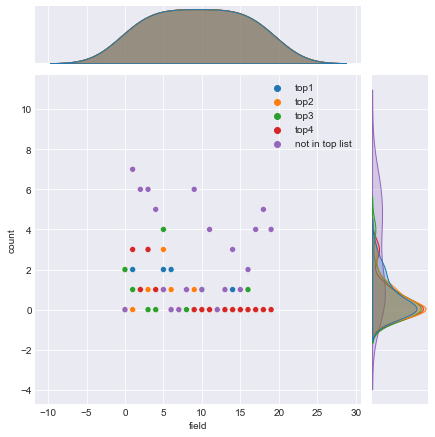

In [7]:
plt.figure(dpi=1000)
figer = sns.jointplot(top.iloc[0:,1:])
figer.set_axis_labels(xlabel="field",ylabel="count")
plt.savefig("fieldWithindexM2.svg",dpi=1000)

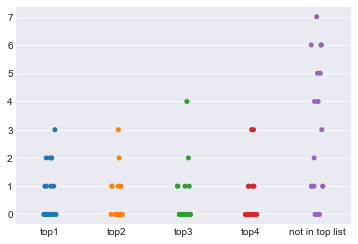

In [8]:
figer = sns.stripplot(top.iloc[0:,1:])
plt.savefig("timesOfcatergoryM2.svg",dpi =1000)

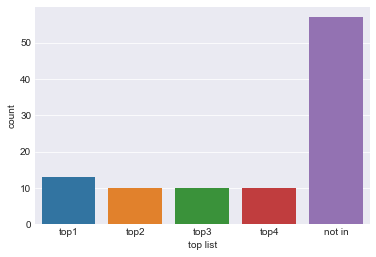

In [9]:
times =[["top1","top2","top3","top4","not in"],
        [0,0,0,0,0]
        ]
for i in range(1,6):
    times[1][i-1]=np.sum(top.iloc[0:,i])
figer = sns.barplot(y=times[1],x=times[0],errorbar=None)
figer.set_ylabel("count")
figer.set_xlabel("top list")
plt.savefig("m11result.svg",dpi = 1000)

In [10]:
student.head(5)

,student,category1,category2,category3,category4,supervisor1,supervisor2,supervisor3,supervisor4
0,1,18,6,0,4,26,2,13,20
1,2,10,3,1,2,9,22,24,20
2,3,8,3,18,11,20,10,13,15
3,4,10,13,12,5,1,14,11,24
4,5,10,9,5,2,5,2,30,28


In [11]:
tutorslist.head(5)

,supervisor,category1,category2,category3,category4,lower,upper
0,1,3,4,6,1,2,5
1,2,15,2,3,1,2,4
2,3,17,2,6,5,3,6
3,4,11,6,2,5,3,7
4,5,3,5,6,4,1,3


In [12]:
times

[['top1', 'top2', 'top3', 'top4', 'not in'], [13.0, 10.0, 10.0, 10.0, 57.0]]